In [109]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from line_profiler import LineProfiler

import gaez_data_loader
import simulation
import toolbox
import importlib
importlib.reload(simulation)
importlib.reload(toolbox)
importlib.reload(gaez_data_loader)

<module 'gaez_data_loader' from 'C:\\Users\\leoko\\PycharmProjects\\pythonProject\\gaez_data_loader.py'>

Map has  6 unique values.
They are [0 3 4 5 6 7]


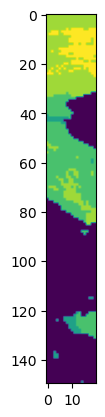

In [110]:
# Load Moisture regime data
data_dir = r"C:\Users\leoko\Documents\Vienna_CSH\gaez_v4_data"
fn = "Gaez_Moisture_Regime_Class.tif"

gaez_data = gaez_data_loader.GlobalAezV4()
gaez_data.load(os.path.join(data_dir, fn), idx=0, verbose=False)
gaez_data.set_woi(r0=500, c0=2300, n_rows=150, n_cols=20) # crop europe  150 before
# gaez_data.get_distance_matrix(verbose=True) # load distance matrix

moisture_data = np.copy(gaez_data._array)

plt.imshow(moisture_data) # visualize

print("Map has ", np.unique(gaez_data._array).size, "unique values.")

print("They are", np.unique(gaez_data._array))


 Loaded image has resolution:  (2160, 4320)

 Latitude cell size [km] for that image is:  9.25925925925926

 Latitude cell size [deg] for that image is:  0.08333333333333333
Map has  8 unique values.
They are [ 0  3  4  5  6  7  8 10]


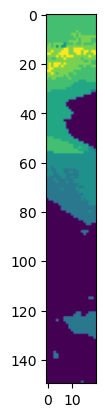

In [111]:
# Load Thermal regime data
data_dir = r"C:\Users\leoko\Documents\Vienna_CSH\gaez_v4_data"
fn = "Gaez_Thermal_Regime_Class.tif"

gaez_data = gaez_data_loader.GlobalAezV4()
gaez_data.load(os.path.join(data_dir, fn), idx=0, verbose=True)
gaez_data.set_woi(r0=500, c0=2300, n_rows=150, n_cols=20) # crop europe
# gaez_data.get_distance_matrix(verbose=True) # load distance matrix

temp_data = np.copy(gaez_data._array)

plt.imshow(temp_data) # visualize

print("Map has ", np.unique(gaez_data._array).size, "unique values.")

print("They are", np.unique(gaez_data._array))

Map has  15 unique values.
They are [ 0  3  8  9 11 14 16 17 24 25 28 29 31 32 34]


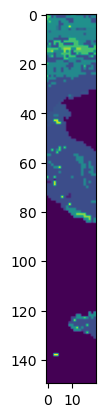

In [112]:
# Load Soil Data
data_dir = r"C:\Users\leoko\Documents\Vienna_CSH\gaez_v4_data"
fn = "Gaez_Dominant_Soil_Class.tif"

gaez_data = gaez_data_loader.GlobalAezV4()
gaez_data.load(os.path.join(data_dir, fn), idx=0, verbose=False)


# gaez_data.resize(target_size=(2160, 4320))  # shape of moisture and temperature class

gaez_data.set_woi(r0=500, c0=2300, n_rows=150, n_cols=20) # crop europe
# gaez_data.get_distance_matrix(verbose=True) # load distance matrix

soil_data = np.copy(gaez_data._array)

plt.imshow(soil_data) # visualize

print("Map has ", np.unique(gaez_data._array).size, "unique values.")

print("They are", np.unique(gaez_data._array))


 Loaded image has resolution:  (2160, 4320)

 Latitude cell size [km] for that image is:  9.25925925925926

 Latitude cell size [deg] for that image is:  0.08333333333333333
Map has  10 unique values.
They are [0 1 2 3 4 5 6 7 8 9]


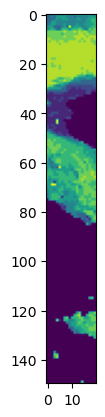

In [113]:
# Load Thermal regime data
data_dir = r"C:\Users\leoko\Documents\Vienna_CSH\gaez_v4_data"
fn = "Gaez_Median_Slope_Class.tif"

gaez_data = gaez_data_loader.GlobalAezV4()
gaez_data.load(os.path.join(data_dir, fn), idx=0, verbose=True)
gaez_data.set_woi(r0=500, c0=2300, n_rows=150, n_cols=20) # crop europe
# gaez_data.get_distance_matrix(verbose=True) # load distance matrix

slope_data = np.copy(gaez_data._array)

plt.imshow(slope_data) # visualize

print("Map has ", np.unique(gaez_data._array).size, "unique values.")

print("They are", np.unique(gaez_data._array))

Text(0.5, 1.0, 'Median slope regime')

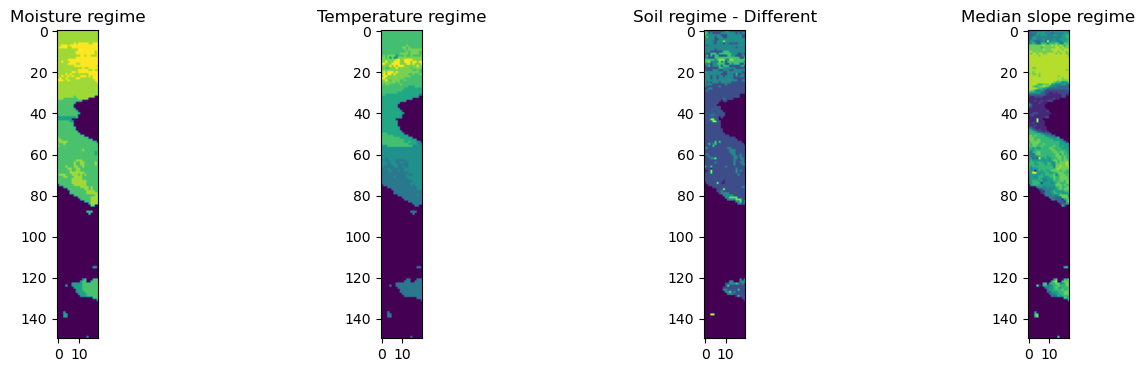

In [114]:
_, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=(16, 4))

ax1.imshow(moisture_data)
ax2.imshow(temp_data)
ax3.imshow(soil_data)
ax4.imshow(slope_data)

ax1.set_title("Moisture regime")
ax2.set_title("Temperature regime")
ax3.set_title("Soil regime - Different")
ax4.set_title("Median slope regime")

In [120]:
total_env_list = [moisture_data, temp_data, slope_data]

# Parameters
num_rows, num_cols = moisture_data.shape
num_vars = 4 # number of env. variables
p_0 = 800 # Basic productivity - sets max. population for a single village
pop_min, pop_max = 70, 100 # Min and max population for a village to split

# Updating the population dynamics
sim_steps = 40_000
rate = 1 / 5 # Growth coefficient in equation (1) - denotes time

# If too small, population will overshoot and array will get clipped.
# For an env. vector of length N, the worst prod. is zero, and the next-worst prod. is 1 / N
# So a reasonable setting is 1 / (4 * N) * p_0 imo
# p_min = 1 / (8 * num_vars) * p_0
p_min = 0 # If None, population gets clipped to zero in each update of the logistic ODE

# Single lattice with seed 50
lattice = simulation.Lattice(n_rows=num_rows, n_cols=num_cols, steps_sim=sim_steps, seed=50, idx_start=(0, 0),
                             num_env_vars=num_vars, pop_min=pop_min, pop_max=pop_max, env=None,
                             rate_growth=rate, prod_min=p_min, rate_prod=p_0)

# load environment
_ = lattice.load_multiple_envs(total_env_list, water_var=0)

# update population
print("Productivity varies in steps", lattice.rate_prod / lattice.num_env_vars)

lattice.pop_max = 5 * np.floor(lattice.rate_prod / lattice.num_env_vars)
lattice.pop_min = 2 * np.floor(lattice.rate_prod / lattice.num_env_vars)

threshold_for_migration = 2 * np.floor(lattice.rate_prod / lattice.num_env_vars)  # requires two matching skills

lattice.num_skill_vars = lattice.num_env_vars
lattice.skills = np.zeros_like(lattice.env)
# lattice.skills[lattice.r0, lattice.c0] = lattice.rng.integers(size=lattice.num_skill_vars, low=0, high=1, endpoint=True)
lattice.skills[lattice.r0, lattice.c0] = lattice.env[lattice.r0, lattice.c0]  # start with perfect match

# for i in range(10):
#     for j in range(10):
#         print(lattice.env[i, j])

print(lattice.skills[lattice.r0, lattice.c0])

In Lattice.init().: To avoid negative population, clip population to zero.
Cell productivity varies in steps 200. In case of GAEZ env., this is also the maximum productivity.
Productivity varies in steps 33.333333333333336
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


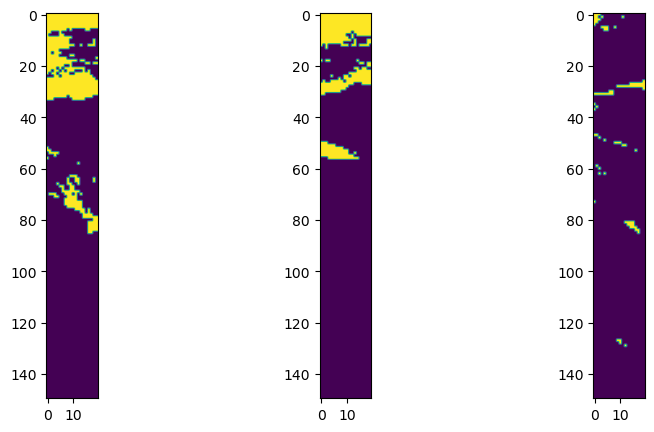

In [121]:
_, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(10, 5))

ax1.imshow(lattice.env[..., 4])
ax2.imshow(lattice.env[..., 11])
ax3.imshow(lattice.env[..., 17])

In [122]:
# Run with line profiler
profiler_line = LineProfiler()
profiler_line.enable_by_count()
profiler_line.add_function(lattice.migrate_to)

lattice.set_search_params(prod_threshold=threshold_for_migration, neigh_type="von_neumann", distance=2,
                          search_intelligently=True, max_distance_km=None)
lattice.set_evolution_params(env_mutation_rate=None, skill_mutation_rate=0.1, mutation_method="4_rates",
                             repopulate_empty_cells=True, metropolis_scale=10)
# check = []
# for _ in tqdm(range(1_000)):
#      lattice.move_forward()
#      lattice.num_iter += 1
#      check.append(lattice.skills[lattice.r0, lattice.c0])

lattice.run(disable_progress_bar=False, track_skill_start=True)

profiler_line.print_stats()

100%|██████████| 39999/39999 [11:53<00:00, 56.08it/s] 

Timer unit: 1e-07 s

Total time: 597.317 s
File: C:\Users\leoko\PycharmProjects\pythonProject\simulation.py
Function: migrate_to at line 365

Line #      Hits         Time  Per Hit   % Time  Line Contents
   365                                               def migrate_to(self, idx_r, idx_c, search_empty_cells=True):
   366                                                   """ This is the core loop that is intended for NUMBA to vastly speed up the FOR loop.
   367                                                   Loops through occupied cells, selects a migration location for each cell based on a prob. distribution."""
   368                                           
   369                                                   # Loop through non-zero cells
   370   9371713   64665949.0      6.9      1.1          for rr, cc in zip(idx_r, idx_c):
   371   9371713  231399718.0     24.7      3.9              candidates_r = self.indices_r + rr  # get index mask
   372   9371713  167820544.0    

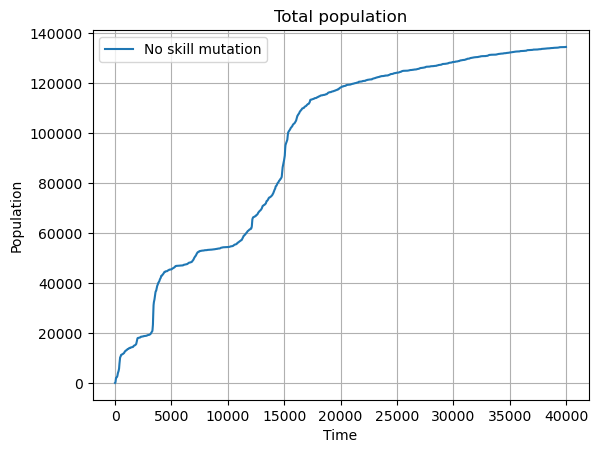

In [123]:
# Get entire population
fig = plt.figure()

pop_t = lattice.population

pop_t[np.isnan(pop_t)] = 0 # to clean for NaN values
pop_total = np.sum(pop_t, axis=(1, 2))

plt.plot(pop_total[:-1], label="No skill mutation")
plt.grid()
plt.xlabel("Time")
plt.ylabel("Population")
plt.title("Total population")
plt.legend()

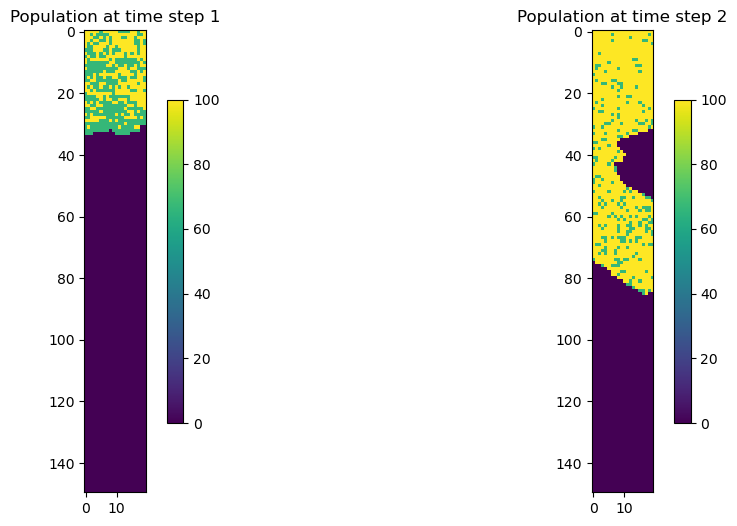

In [124]:
_, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

plot1 = ax1.imshow(lattice.population[10000, :, :])
ax1.set_title("Population at time step 1")
fig.colorbar(plot1, ax=ax1, shrink=0.7)

plot2 = ax2.imshow(lattice.population[-1, :, :])
ax2.set_title("Population at time step 2")
fig.colorbar(plot2, ax=ax2, shrink=0.7)

In [106]:
print(lattice.env[120, 184])

print(lattice.skills[120, 184])

[0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [135]:
# Parameters
num_rows, num_cols = 40, 40
num_vars = 4 # number of env. variables
p_0 = 800 # Basic productivity - sets max. population for a single village
pop_min, pop_max = 50, 150 # Min and max population for a village to split

# Updating the population dynamics
sim_steps = 5_000
rate = 1 / 30 # Growth coefficient in equation (1) - denotes time

# If too small, population will overshoot and array will get clipped.
# For an env. vector of length N, the worst prod. is zero, and the next-worst prod. is 1 / N
# So a reasonable setting is 1 / (4 * N) * p_0 imo
# p_min = 1 / (8 * num_vars) * p_0
p_min = 0 # If None, population gets clipped to zero in each update of the logistic ODE

# Single lattice with seed 50
lattice = simulation.Lattice(n_rows=num_rows, n_cols=num_cols, steps_sim=sim_steps, seed=50, idx_start=(0, 0),
                             num_env_vars=num_vars, pop_min=pop_min, pop_max=pop_max, env=None,
                             rate_growth=rate, prod_min=p_min, rate_prod=p_0)

In Lattice.init().: To avoid negative population, clip population to zero.
Cell productivity varies in steps 200. In case of GAEZ env., this is also the maximum productivity.
